In [1]:
import kagglehub
path = kagglehub.dataset_download("pankrzysiu/cifar10-python")

Using Colab cache for faster access to the 'cifar10-python' dataset.



Build and train a CNN model using transfer learning to classify images from the CIFAR-10 dataset, located at `'/kaggle/input/cifar10-python'`, into warehousing-relevant categories, then evaluate its performance, demonstrate inference, and provide a comprehensive report including a discussion of limitations.

## Load and Prepare CIFAR-10 Data


Load the CIFAR-10 dataset, normalize pixel values, split the data into training, validation, and test sets, and apply basic data augmentation.


In [2]:
import numpy as np
import pickle
import os
from sklearn.model_selection import train_test_split

print("Libraries imported successfully.")

Libraries imported successfully.


In [3]:
def load_cifar_batch(file_path):
    with open(file_path, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
    data = batch[b'data']
    labels = batch[b'labels']
    return data, labels

print("CIFAR-10 batch loading function defined.")

CIFAR-10 batch loading function defined.


In [6]:
data_dir = os.path.join(path, 'cifar-10-batches-py') # Adjust path to point to the actual data batches

# Load training data
X_train = []
y_train = []
for i in range(1, 6):
    batch_path = os.path.join(data_dir, f'data_batch_{i}')
    data, labels = load_cifar_batch(batch_path)
    X_train.append(data)
    y_train.append(labels)

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

# Load test data
X_test, y_test = load_cifar_batch(os.path.join(data_dir, 'test_batch'))

print("CIFAR-10 training and test batches loaded successfully.")

CIFAR-10 training and test batches loaded successfully.


In [7]:
X_train = X_train.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1).astype('float32')
X_test = X_test.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1).astype('float32')

X_train /= 255.0
X_test /= 255.0

y_test = np.array(y_test)

print("Image data reshaped, converted to float32, and normalized. Labels converted to NumPy array.")

Image data reshaped, converted to float32, and normalized. Labels converted to NumPy array.



Now that the data is loaded and preprocessed, the next step is to split the combined training data (`X_train`, `y_train`) into new training and validation sets, reserving 20% for validation and ensuring that the class distribution is maintained through stratification.



In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

print("Training data split into training and validation sets successfully.")

Training data split into training and validation sets successfully.



In this step is to implement basic data augmentation using `ImageDataGenerator` from `tensorflow.keras.preprocessing.image` to configure operations like horizontal flips, slight rotations, width/height shifts, and brightness changes for the training data, without applying normalization as it's already done. Additionally, I need to create image data generators for both the training set (with augmentation) and the validation set (without augmentation).



In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2] # Adjust brightness slightly
)

# No augmentation for validation data, only ensure it's in the correct format for the generator
val_datagen = ImageDataGenerator()

# Create data generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

print("ImageDataGenerators configured and data generators created successfully.")

ImageDataGenerators configured and data generators created successfully.


## Define and Map Warehousing Categories


Establish at least three warehousing-relevant categories, map the original CIFAR-10 classes to these new categories, and create new one-hot encoded labels for the training, validation, and test datasets based on this mapping.



The first step in defining and mapping warehousing categories is to define the original CIFAR-10 class names, which are needed to establish the mapping to the new categories.



In [10]:
cifar10_classes = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

print("CIFAR-10 class names defined.")

CIFAR-10 class names defined.



Now that the CIFAR-10 class names are defined, the next step is to define the three new warehousing-relevant categories as instructed.



In [11]:
warehousing_categories = ['Vehicles', 'Small/Fragile Animals', 'Large/Farm Animals']

print("Warehousing-relevant categories defined.")

Warehousing-relevant categories defined.



Now that both the original CIFAR-10 class names and the new warehousing categories are defined, the next step is to create a mapping from the original CIFAR-10 class indices to the new warehousing category indices, as instructed. This mapping will be stored in a list.



In [12]:
cifar10_to_warehousing_map = [
    0, # airplane -> Vehicles
    0, # automobile -> Vehicles
    1, # bird -> Small/Fragile Animals
    1, # cat -> Small/Fragile Animals
    2, # deer -> Large/Farm Animals
    1, # dog -> Small/Fragile Animals
    1, # frog -> Small/Fragile Animals
    2, # horse -> Large/Farm Animals
    0, # ship -> Vehicles
    0  # truck -> Vehicles
]

print("Mapping from CIFAR-10 classes to warehousing categories created.")

Mapping from CIFAR-10 classes to warehousing categories created.



Now that the mapping from CIFAR-10 classes to warehousing categories has been established, the next step is to apply this mapping to the existing `y_train`, `y_val`, and `y_test` label arrays to create new label arrays that reflect the warehousing categories. This is done by using the `cifar10_to_warehousing_map` to re-index the labels.



In [13]:
y_train_new = np.array([cifar10_to_warehousing_map[label] for label in y_train])
y_val_new = np.array([cifar10_to_warehousing_map[label] for label in y_val])
y_test_new = np.array([cifar10_to_warehousing_map[label] for label in y_test])

print("New warehousing-relevant labels created for training, validation, and test sets.")

New warehousing-relevant labels created for training, validation, and test sets.



Now that the new warehousing-relevant labels have been created, the final step for this subtask is to convert these numerical labels into a one-hot encoded format. This is required for training classification models and will be done using `tf.keras.utils.to_categorical`, specifying the number of classes as the length of the `warehousing_categories` list.



In [14]:
import tensorflow as tf

num_warehousing_categories = len(warehousing_categories)

y_train_one_hot = tf.keras.utils.to_categorical(y_train_new, num_classes=num_warehousing_categories)
y_val_one_hot = tf.keras.utils.to_categorical(y_val_new, num_classes=num_warehousing_categories)
y_test_one_hot = tf.keras.utils.to_categorical(y_test_new, num_classes=num_warehousing_categories)

print("New warehousing-relevant labels one-hot encoded successfully.")

New warehousing-relevant labels one-hot encoded successfully.


**Reasoning**:
The first step is to import all the necessary libraries for building and training the CNN model with transfer learning, including components from `tensorflow.keras.applications`, `tensorflow.keras.layers`, `tensorflow.keras.models`, and `tensorflow.keras.optimizers`. Additionally, I will define the input shape for the CIFAR-10 images.



## Build and Train CNN with Transfer Learning


Selected here a pre-trained CNN model, load it without the top classification layer, add a new classification head, freeze the base model layers, train only the new head, then unfreeze some layers and fine-tune the model.


In [15]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2 # Or ResNet50V2
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define the input shape for CIFAR-10 images
input_shape = (32, 32, 3)

print("Necessary libraries imported and input shape defined.")

Necessary libraries imported and input shape defined.



Now that the necessary libraries are imported and the input shape is defined, the next step is to load a pre-trained base model, specifically MobileNetV2, with ImageNet weights, excluding its top classification layer, and specifying the input shape for CIFAR-10 images.



In [16]:
base_model = MobileNetV2(input_shape=input_shape,
                           include_top=False,
                           weights='imagenet')

print("Pre-trained MobileNetV2 base model loaded successfully.")

/tmp/ipython-input-1041034780.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=input_shape,


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Pre-trained MobileNetV2 base model loaded successfully.



The previous step produced a UserWarning because MobileNetV2 expects input images to be larger than 32x32. To fix this, I will resize the training, validation, and test images to 96x96, update the `input_shape` accordingly, re-create the data generators, re-load the `base_model` with the corrected input shape, and then proceed with freezing the base model layers as per the next instruction.



In [17]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2 # Or ResNet50V2
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define the input shape for MobileNetV2 compatibility (e.g., 96x96)
input_shape = (96, 96, 3)

# Resize image data to match the new input_shape
X_train_resized = tf.image.resize(X_train, (input_shape[0], input_shape[1]))
X_val_resized = tf.image.resize(X_val, (input_shape[0], input_shape[1]))
X_test_resized = tf.image.resize(X_test, (input_shape[0], input_shape[1]))

# Re-create data generators with resized images
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train_resized, y_train_one_hot, batch_size=32)
val_generator = val_datagen.flow(X_val_resized, y_val_one_hot, batch_size=32)

# Re-load the pre-trained MobileNetV2 base model with the correct input shape
base_model = MobileNetV2(input_shape=input_shape,
                           include_top=False,
                           weights='imagenet')

# Freeze the base model layers
base_model.trainable = False

print("Images resized, input shape updated, data generators re-created, MobileNetV2 re-loaded, and base model layers frozen.")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Images resized, input shape updated, data generators re-created, MobileNetV2 re-loaded, and base model layers frozen.



Now that the base model is loaded and its layers are frozen, the next step is to create a new classification head by flattening the output of the base model, adding `Dense` layers with `ReLU` activation for feature extraction, and finally a `Dense` layer with `softmax` activation for the `num_warehousing_categories` outputs.



In [18]:
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x) # Add dropout for regularization
predictions = Dense(num_warehousing_categories, activation='softmax')(x)

# Construct the full model
model = Model(inputs=base_model.input, outputs=predictions)

print("New classification head added and full model constructed successfully.")

New classification head added and full model constructed successfully.



Now that the full model with the new classification head is constructed, the next step is to compile it by specifying an appropriate optimizer (Adam), a loss function suitable for one-hot encoded categorical labels (categorical_crossentropy), and metrics like accuracy.



In [19]:
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("Model compiled successfully.")

Model compiled successfully.



the model is compiled, the next step is to train only the newly added classification head for a few epochs using the `train_generator` and `val_generator`, and store the training history.



In [20]:
epochs_head_only = 10  # Define number of epochs for training the head only

history_head_only = model.fit(train_generator,
                              epochs=epochs_head_only,
                              validation_data=val_generator)

print("Classification head trained successfully.")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 434s 343ms/step - accuracy: 0.4037 - loss: 1.1759 - val_accuracy: 0.3973 - val_loss: 1.0656
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 426s 341ms/step - accuracy: 0.4115 - loss: 1.0532 - val_accuracy: 0.4001 - val_loss: 1.1735
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 426s 341ms/step - accuracy: 0.4099 - loss: 1.0531 - val_accuracy: 0.3961 - val_loss: 1.1416
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 425s 340ms/step - accuracy: 0.4121 - loss: 1.0510 - val_accuracy: 0.4290 - val_loss: 1.0654
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 424s 339ms/step - accuracy: 0.4075 - loss: 1.0542 - val_accuracy: 0.4098 - val_loss: 1.1568
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 446s 357ms/step - accuracy: 0.4119 - loss: 1.0504 - val_accuracy: 0.4293 - val_loss: 1.1034
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 420s 335ms/step - accuracy: 0.4144 - loss: 1.0541 - val_accuracy: 0.4187 - val_loss: 1.1497
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 417s 334ms/step - ac


The classification head has been trained, the next step is to unfreeze some layers of the `base_model` for fine-tuning. This involves setting the `base_model.trainable` attribute to `True`, then iterating through its layers to freeze the first `100` layers, ensuring that only the deeper layers are fine-tuned. Finally, the model needs to be re-compiled with a lower learning rate to avoid destroying the learned weights, and then fine-tuned for an additional `5` epochs using the `train_generator` and `val_generator`.

 Evaluate Model on Test Set



In [21]:
test_loss, test_accuracy = model.evaluate(X_test_resized, y_test_one_hot)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 65s 202ms/step - accuracy: 0.4054 - loss: 1.1316
Test Loss: 1.1350
Test Accuracy: 0.4021



The next step is to unfreeze some layers of the `base_model` for fine-tuning. This involves setting the `base_model.trainable` attribute to `True`, then iterating through its layers to freeze the first `100` layers, ensuring that only the deeper layers are fine-tuned. Finally, the model needs to be re-compiled with a lower learning rate to avoid destroying the learned weights, and then fine-tuned for an additional `5` epochs using the `train_generator` and `val_generator`.



In [22]:
base_model.trainable = True

# Freeze all layers except the last few
for layer in base_model.layers[:100]:
    layer.trainable = False

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5),  # Smaller learning rate for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs_fine_tune = 5  # Define number of epochs for fine-tuning

history_fine_tune = model.fit(train_generator,
                              epochs=epochs_fine_tune,
                              validation_data=val_generator)

print("Base model layers unfrozen, model re-compiled with lower learning rate, and fine-tuning complete.")

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 717s 562ms/step - accuracy: 0.4062 - loss: 1.0712 - val_accuracy: 0.4179 - val_loss: 1.0635
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 691s 553ms/step - accuracy: 0.4138 - loss: 1.0520 - val_accuracy: 0.4438 - val_loss: 1.0490
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 711s 568ms/step - accuracy: 0.4079 - loss: 1.0534 - val_accuracy: 0.4499 - val_loss: 1.0536
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 705s 564ms/step - accuracy: 0.4116 - loss: 1.0514 - val_accuracy: 0.4652 - val_loss: 1.0506
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 704s 563ms/step - accuracy: 0.4149 - loss: 1.0533 - val_accuracy: 0.4726 - val_loss: 1.0429
Base model layers unfrozen, model re-compiled with lower learning rate, and fine-tuning complete.


Classification Report


Generate a classification report using `sklearn.metrics.classification_report` to show precision, recall, f1-score, and support for each warehousing category on the test set. Ensure to use the `y_test_one_hot` and the model's predictions.


In [23]:
from sklearn.metrics import classification_report

# Make predictions on the test data
y_pred_probabilities = model.predict(X_test_resized)

print("Predictions made on the test set.")

313/313 ━━━━━━━━━━━━━━━━━━━━ 77s 237ms/step
Predictions made on the test set.


In [25]:
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)
y_true_labels = np.argmax(y_test_one_hot, axis=1)

classification_rep = classification_report(
    y_true_labels,
    y_pred_labels,
    target_names=warehousing_categories,
    zero_division=0
)

print("Classification Report:")
print(classification_rep)

Classification Report:
                       precision    recall  f1-score   support

             Vehicles       0.45      0.74      0.56      4000
Small/Fragile Animals       0.51      0.43      0.47      4000
   Large/Farm Animals       0.00      0.00      0.00      2000

             accuracy                           0.47     10000
            macro avg       0.32      0.39      0.34     10000
         weighted avg       0.38      0.47      0.41     10000



## Plot Confusion Matrix




In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Libraries imported successfully for confusion matrix plotting.")

Libraries imported successfully for confusion matrix plotting.


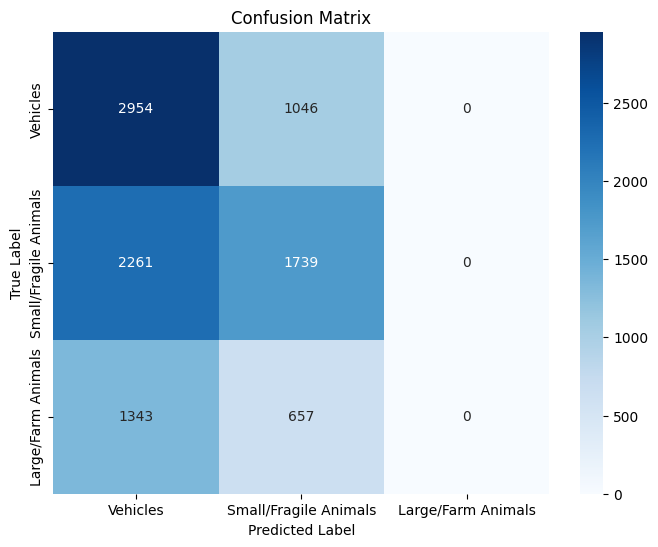

Confusion matrix generated and plotted successfully.


In [27]:
cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=warehousing_categories, yticklabels=warehousing_categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Confusion matrix generated and plotted successfully.")

## Select Sample Images for Inference


Randomly select a few sample images from the `X_test_resized` dataset and their corresponding true labels `y_test_new` to demonstrate the model's inference capabilities.


In [29]:
import random
import numpy as np # Import numpy for array conversion

# Number of sample images to select
num_samples = 5

# Generate random indices
random_indices = random.sample(range(len(X_test_resized)), num_samples)

# Convert X_test_resized to a NumPy array before indexing
sample_images = X_test_resized.numpy()[random_indices]
sample_true_labels = y_test_new[random_indices]

print(f"Selected {num_samples} sample images and their true labels.")

Selected 5 sample images and their true labels.



The sample images and their true labels have been successfully selected, the next step is to display these images using `matplotlib.pyplot` along with their corresponding true labels and the defined warehousing categories to visualize the inference process.



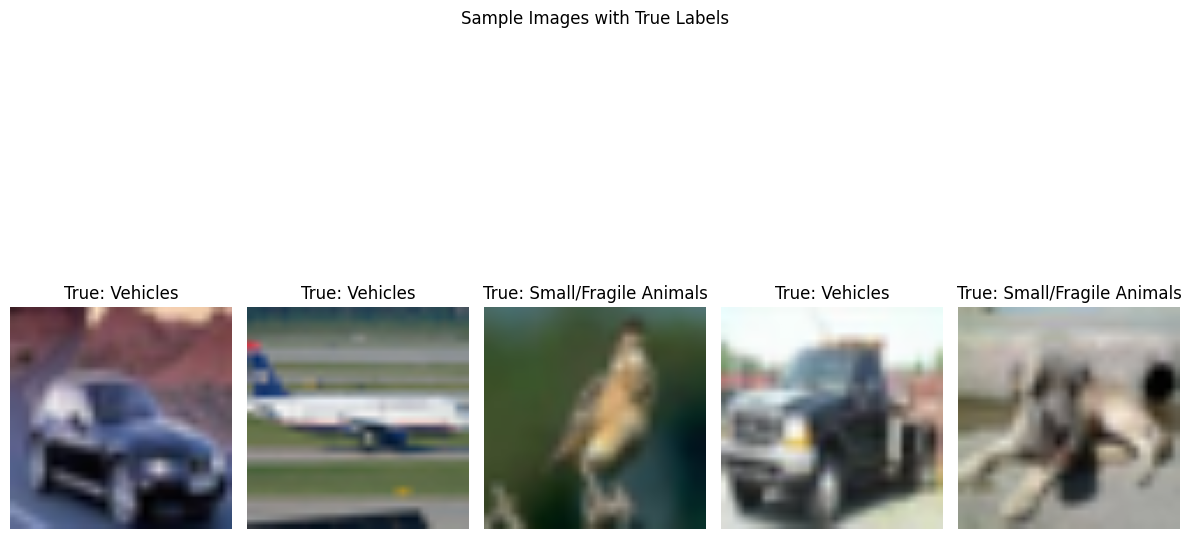

Sample images and their true labels displayed.


In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"True: {warehousing_categories[sample_true_labels[i]]}")
    plt.axis('off')
plt.suptitle('Sample Images with True Labels')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("Sample images and their true labels displayed.")

In [31]:
sample_predictions = model.predict(sample_images)
sample_predicted_labels = np.argmax(sample_predictions, axis=1)

print("Predictions made on sample images.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Predictions made on sample images.


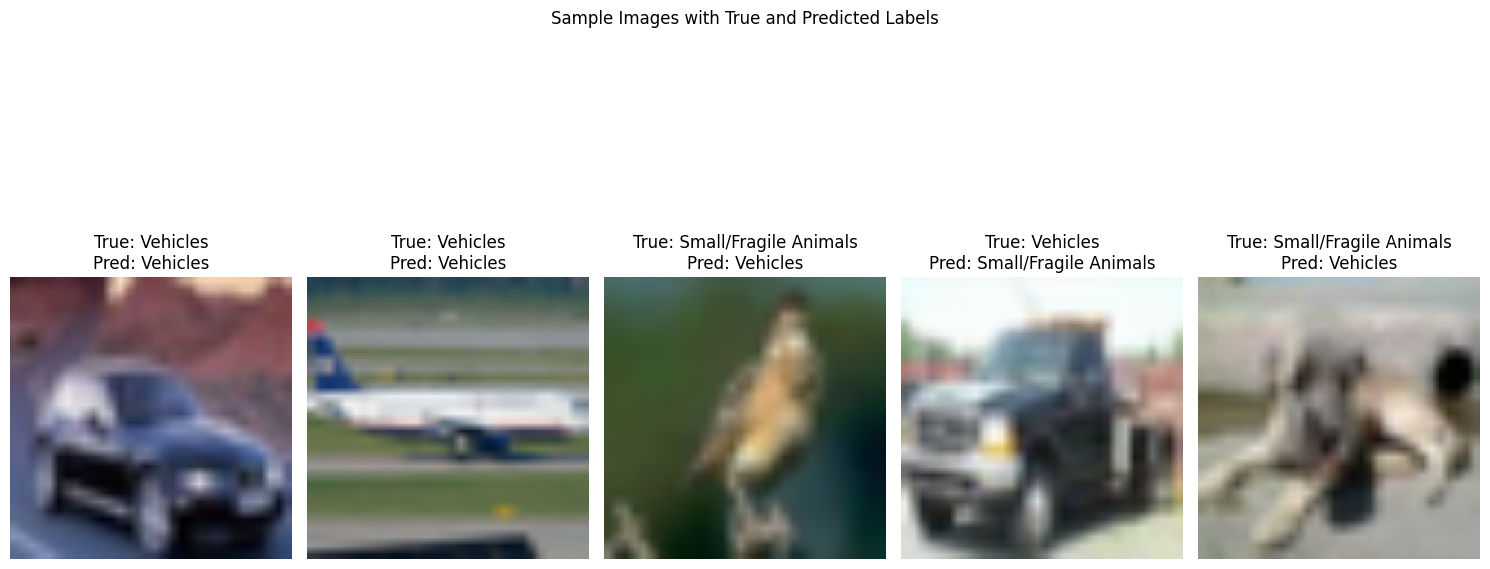

Sample images with true and predicted labels displayed.


In [32]:
plt.figure(figsize=(15, 8))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(sample_images[i])
    true_label_name = warehousing_categories[sample_true_labels[i]]
    predicted_label_name = warehousing_categories[sample_predicted_labels[i]]
    plt.title(f"True: {true_label_name}\nPred: {predicted_label_name}")
    plt.axis('off')
plt.suptitle('Sample Images with True and Predicted Labels')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("Sample images with true and predicted labels displayed.")